In [295]:
!pip install requests

In [296]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
params = {
    "vs_currency": "usd",
    "days": "365",
    "interval": "daily"
}
response = requests.get(url, params=params)
data = response.json()
timestamps = [entry[0] for entry in data["prices"]]
prices = [entry[1] for entry in data["prices"]]
df = pd.DataFrame({"Date": pd.to_datetime(timestamps, unit="ms"), "Price": prices})
df.set_index("Date", inplace=True)
print(df.head())
df.to_csv("bitcoin_prices.csv")

                   Price
Date                    
2024-03-14  73097.767027
2024-03-15  71420.031801
2024-03-16  69497.763193
2024-03-17  65292.313293
2024-03-18  68425.415656


In [297]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Price"], label="Bitcoin Price (USD)", color="blue")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Bitcoin Price Trend (Last 1 Year)")

Text(0.5, 1.0, 'Bitcoin Price Trend (Last 1 Year)')

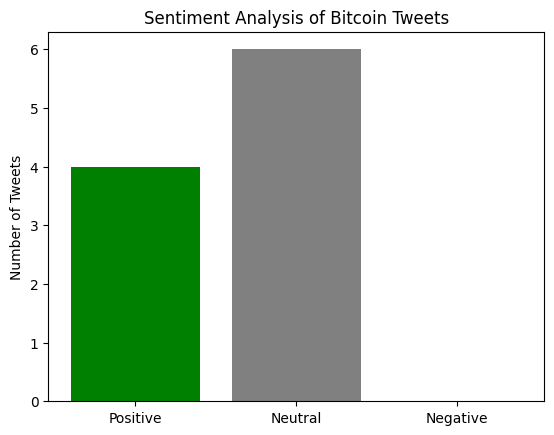

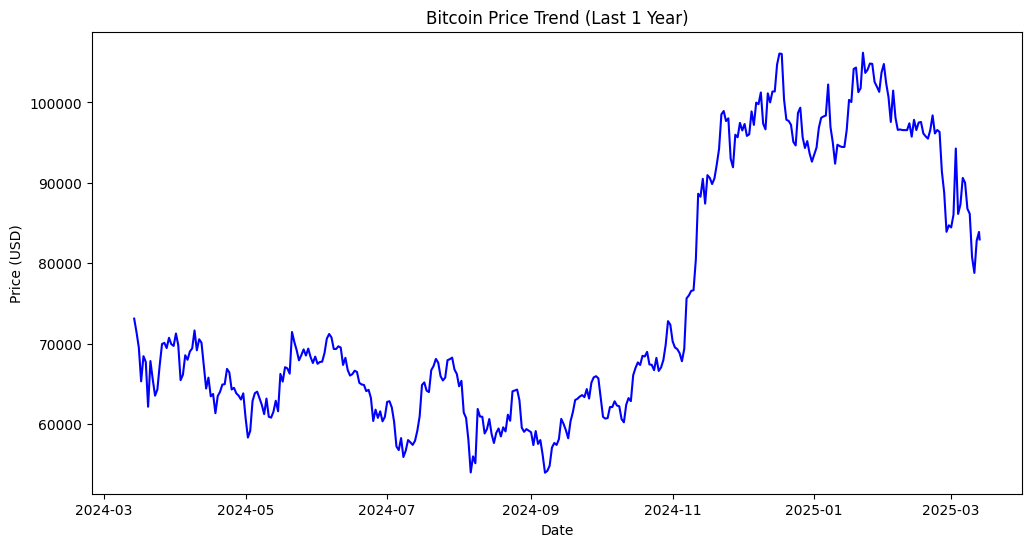

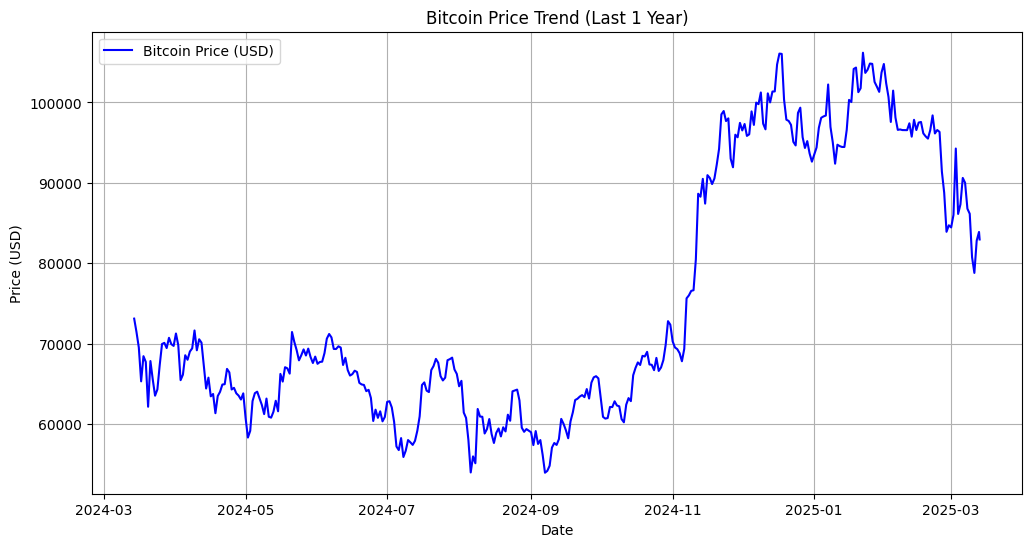

In [298]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Price"], label="Bitcoin Price (USD)", color="blue")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Bitcoin Price Trend (Last 1 Year)")
plt.legend()
plt.grid()
plt.show()

In [299]:
!pip install statsmodels tensorflow keras prophet

In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv("/content/bitcoin_prices.csv", parse_dates=['Date'], index_col='Date')
print(df.head())

                   Price
Date                    
2024-03-14  73097.767027
2024-03-15  71420.031801
2024-03-16  69497.763193
2024-03-17  65292.313293
2024-03-18  68425.415656


In [301]:
#Train ARIMA Model
model_arima = ARIMA(df['Price'], order=(5,1,0))
model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.forecast(steps=30)

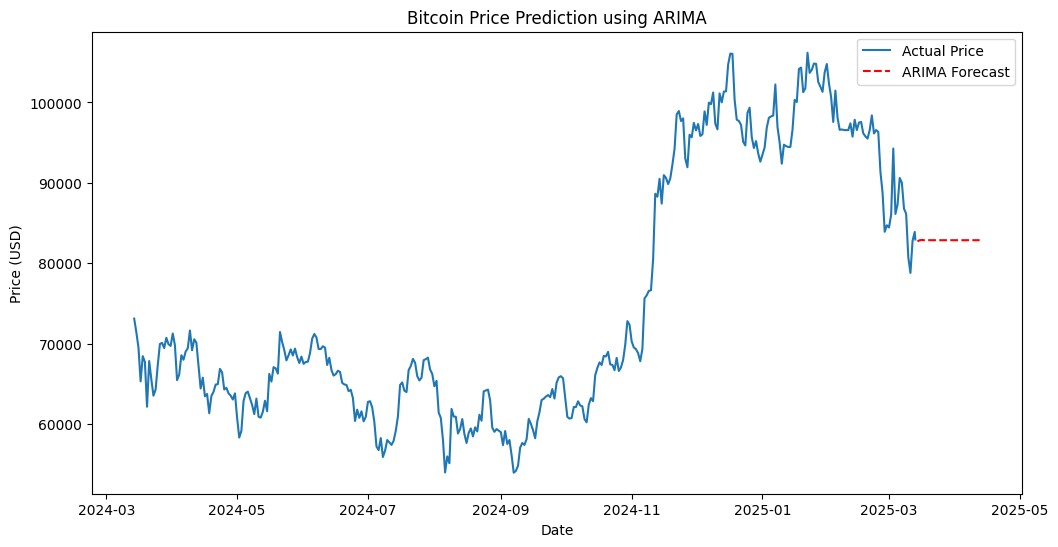

In [302]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Price"], label="Actual Price")
plt.plot(pd.date_range(start=df.index[-1], periods=31, freq="D")[1:], forecast_arima, label="ARIMA Forecast", linestyle="dashed", color="red")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Bitcoin Price Prediction using ARIMA")
plt.legend()
plt.show()

In [303]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df["Price"].values.reshape(-1,1))
def create_dataset(data, time_step=60):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [304]:
time_step = 60
X, Y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [305]:
#Build and train LSTM Model
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

In [306]:
model_lstm.compile(optimizer="adam", loss="mean_squared_error")
model_lstm.fit(X_train, Y_train, batch_size=1, epochs=10)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.0236
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0080
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0056
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0055
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.0047
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0032
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0029
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0028
Epoch 9/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.0039
Epoch 10/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0035


In [307]:
#forecast with LSTM predict last 30 days
X_input = scaled_data[-time_step:].reshape(1, time_step, 1)
lstm_predictions = []

for _ in range(30):
    pred = model_lstm.predict(X_input)
    lstm_predictions.append(pred[0,0])
    X_input = np.append(X_input[:,1:,:], pred.reshape(1,1,1), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

In [308]:
lstm_predictions = scaler.inverse_transform(np.array(lstm_predictions).reshape(-1,1))

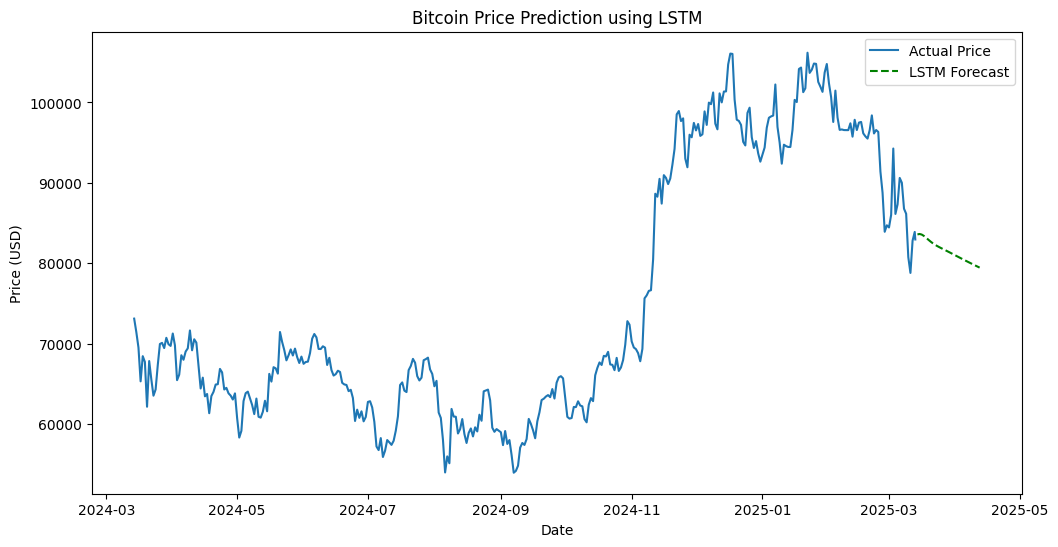

In [309]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Price"], label="Actual Price")
plt.plot(pd.date_range(start=df.index[-1], periods=31, freq="D")[1:], lstm_predictions, label="LSTM Forecast", linestyle="dashed", color="green")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Bitcoin Price Prediction using LSTM")
plt.legend()
plt.show()

In [310]:
#Forecasting with facebook prophet
#prepare data for prophet
df_prophet = df.reset_index()[['Date', 'Price']]
df_prophet.columns = ['ds', 'y']

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprbrmrcze/3v0wm52s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprbrmrcze/gckhner3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66069', 'data', 'file=/tmp/tmprbrmrcze/3v0wm52s.json', 'init=/tmp/tmprbrmrcze/gckhner3.json', 'output', 'file=/tmp/tmprbrmrcze/prophet_modelchxuvr1u/prophet_model-20250313062602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:26:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:26:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


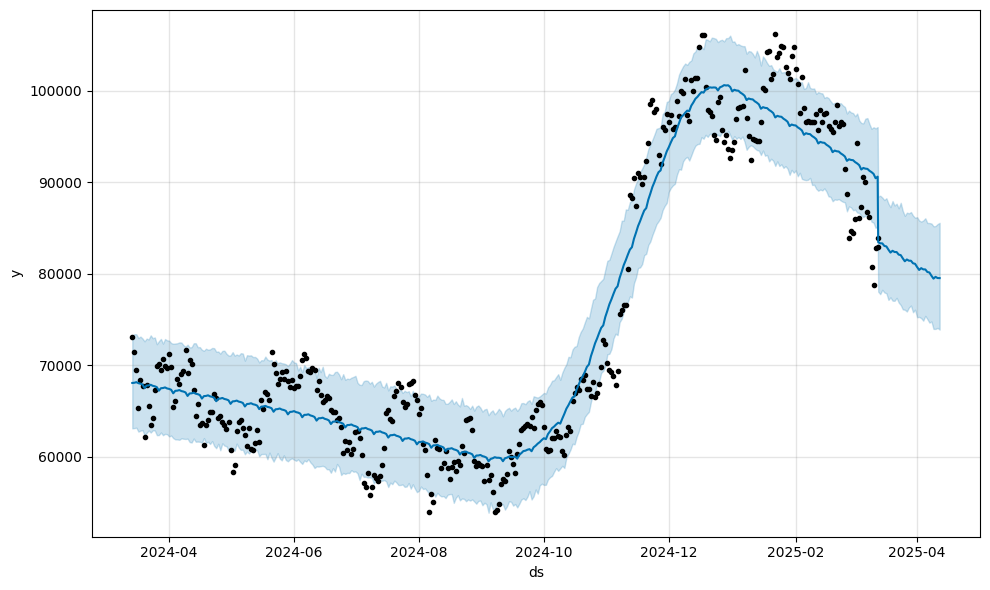

In [311]:
#train prophet model
model_prophet = Prophet()
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=30)
forecast = model_prophet.predict(future)
model_prophet.plot(forecast)
plt.show()

In [312]:
#Evaluate Model Performance
from sklearn.metrics import mean_squared_error
import numpy as np

In [313]:
arima_rmse = np.sqrt(mean_squared_error(df['Price'][-30:], forecast_arima))
print(f"ARIMA RMSE: {arima_rmse}")

ARIMA RMSE: 9608.030568429274


In [314]:
lstm_rmse = np.sqrt(mean_squared_error(df['Price'][-30:], lstm_predictions))
print(f"LSTM RMSE: {lstm_rmse}")

LSTM RMSE: 10160.45195204789


In [315]:
prophet_rmse = np.sqrt(mean_squared_error(df['Price'][-30:].values, forecast['yhat'][-30:].values))
print(f"Prophet RMSE: {prophet_rmse}")

Prophet RMSE: 10335.411295371974


In [316]:
#Tune the Models for Better Predictions
#ARIMA Hyperparameter Tuning (find the best p, d, q)
#LSTM Hyperparameter Tuning (adjust layers, neurons, epochs)
#Prophet Seasonal Adjustments
!pip install pmdarima
from pmdarima import auto_arima

auto_model = auto_arima(df['Price'], seasonal=False, stepwise=True, suppress_warnings=True)
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3302.820
Date:                Thu, 13 Mar 2025   AIC                           6607.640
Time:                        06:26:08   BIC                           6611.540
Sample:                             0   HQIC                          6609.190
                                - 366                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.227e+06   2.17e+05     19.486      0.000     3.8e+06    4.65e+06
Ljung-Box (L1) (Q):                   0.87   Jarque-Bera (JB):                72.45
Prob(Q):                              0.35   Pr

In [317]:
import time
import requests

# Set the number of iterations you want the loop to run for
max_iterations = 5  # For example, stop after 10 iterations

for i in range(max_iterations):
    response = requests.get("https://api.coingecko.com/api/v3/simple/price", params={"ids": "bitcoin", "vs_currencies": "usd"})

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        btc_price = response.json()["bitcoin"]["usd"]
        print(f"Live Bitcoin Price: ${btc_price}")  # This line prints the price
    else:
        print(f"Error fetching price: Status code {response.status_code}") # This line prints an error

    time.sleep(10)  # Wait 10 seconds before fetching again to avoid rate limiting

print("Loop finished.")

Live Bitcoin Price: $82946
Live Bitcoin Price: $82946
Live Bitcoin Price: $82864
Live Bitcoin Price: $82864
Live Bitcoin Price: $82864
Loop finished.


In [318]:
#Deploy as a webapp in streamlit
!pip install streamlit
import streamlit as st

st.title("Bitcoin Price Forecasting")

# Show actual price chart
st.line_chart(df['Price'])

# Show ARIMA forecast
st.line_chart(forecast_arima)

# Show LSTM forecast
st.line_chart(lstm_predictions)

2025-03-13 06:27:01.530 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:01.532 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:01.598 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:01.599 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:01.661 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:01.662 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:01.722 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:01.723 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [319]:
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

Overwriting app.py


In [320]:
df = pd.read_csv("/content/bitcoin_prices.csv", parse_dates=["Date"], index_col="Date")

In [321]:
st.title("Bitcoin Price Forecasting")

2025-03-13 06:27:01.756 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:01.759 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [322]:
# Show Historical Data
st.subheader("Bitcoin Price Data")
st.write(df.tail())

# Plot Actual Prices
st.subheader("Bitcoin Price Trend")
st.line_chart(df["Price"])

2025-03-13 06:27:01.777 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:01.778 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:01.782 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:01.783 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:01.785 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:01.785 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:01.847 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:01.848 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [323]:
# ARIMA Forecast Plot
st.subheader("ARIMA Forecast")
# Adjust the periods in pd.date_range to 31 and keep [1:] to get 30 periods to match forecast_arima
st.line_chart(pd.concat([df["Price"].iloc[-30:], pd.Series(forecast_arima.values, index=pd.date_range(start=df.index[-1], periods=31, freq="D")[1:])]))

2025-03-13 06:27:01.860 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:01.861 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:01.921 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:01.921 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [324]:
st.subheader("LSTM Forecast")
st.line_chart(pd.concat([df["Price"].iloc[-30:], pd.Series(lstm_predictions.flatten(), index=pd.date_range(start=df.index[-1], periods=31, freq="D")[1:])]))
# Change periods to 31 to generate 30 dates after excluding the first with [1:]

2025-03-13 06:27:01.935 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:01.936 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:01.995 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:01.996 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [325]:
!pip install pyngrok
!pip install streamlit pyngrok

In [326]:
!ngrok authtoken 2uBKFFrECRNBHqLtXYKuRepg7tk_6drokNi5jKGReR2aoAdzZ

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [327]:
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

Overwriting app.py


In [328]:
# Load Bitcoin Price Data
df = pd.read_csv("bitcoin_prices.csv", parse_dates=["Date"], index_col="Date")

# Streamlit UI
st.title("📈 Bitcoin Price Forecasting")

2025-03-13 06:27:07.865 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:07.867 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [329]:
# Show Historical Data
st.subheader("Bitcoin Price Data")
st.write(df.tail())

# Plot Actual Prices
st.subheader("Bitcoin Price Trend")
st.line_chart(df["Price"])

st.write("Built with Streamlit")

2025-03-13 06:27:07.880 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:07.883 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:07.885 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:07.886 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:07.887 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:07.888 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:07.980 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:27:07.981 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [330]:
import threading
import subprocess
from pyngrok import ngrok

# Kill any previous Streamlit or ngrok processes
!killall ngrok  # Added this line to kill all ngrok instances
!kill -9 $(pgrep streamlit)

# Start Streamlit in the background
def run_streamlit():
    subprocess.run(["streamlit", "run", "app.py"])

thread = threading.Thread(target=run_streamlit)
thread.start()

# Start ngrok
public_url = ngrok.connect(addr="8501")
print(f"Streamlit App is Running at: {public_url}")

# (Optional) Stop processes when done
!kill -9 $(pgrep streamlit)
!kill -9 $(pgrep ngrok)

Streamlit App is Running at: NgrokTunnel: "https://b57f-35-236-221-231.ngrok-free.app" -> "http://localhost:8501"


In [331]:
!ls

app.py			bitcoin_prices_for_powerbi.csv	live_bitcoin_prices.csv
binancecoin_prices.csv	crypto_dashboard		sample_data
bitcoin_prices.csv	ethereum_prices.csv		updated_arima_forecast.csv


In [332]:
from pyngrok import ngrok

# Start ngrok tunnel with the correct configuration (without "options")
public_url = ngrok.connect(addr="8501")
print(f"Streamlit App is Running at: {public_url}")


Streamlit App is Running at: NgrokTunnel: "https://5b05-35-236-221-231.ngrok-free.app" -> "http://localhost:8501"


In [333]:
%%writefile app.py
import streamlit as st

st.title("Bitcoin Price Forecasting")
st.write("Hello! This is a simple Streamlit app.")

Overwriting app.py


In [334]:
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

# Load Bitcoin Price Data
df = pd.read_csv("bitcoin_prices.csv", parse_dates=["Date"], index_col="Date")

# Streamlit UI
st.title("Bitcoin Price Forecasting")
st.write("Welcome! This dashboard shows Bitcoin price trends and predictions.")

# Show Data Preview
st.subheader("Bitcoin Price Data")
st.write(df.tail())

# Plot Bitcoin Price Trend
st.subheader("Bitcoin Price Trend")
st.line_chart(df["Price"])

st.write("Built with Streamlit")

Overwriting app.py


In [335]:
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

# Load Bitcoin Price Data
df = pd.read_csv("bitcoin_prices.csv", parse_dates=["Date"], index_col="Date")

Overwriting app.py


In [336]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Load Bitcoin data
df = pd.read_csv("bitcoin_prices.csv", parse_dates=["Date"], index_col="Date")

# Train ARIMA model
model_arima = ARIMA(df['Price'], order=(5,1,0))
model_arima_fit = model_arima.fit()

# Forecast the next 30 days
forecast_arima = model_arima_fit.forecast(steps=30)

# Save ARIMA Predictions
df_arima_forecast = pd.DataFrame({"Date": pd.date_range(start=df.index[-1], periods=31, freq="D")[1:], "Forecast": forecast_arima})
df_arima_forecast.to_csv("arima_forecast.csv", index=False)
print("ARIMA Forecast Saved!")


ARIMA Forecast Saved!


In [337]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Load Bitcoin data
df = pd.read_csv("bitcoin_prices.csv", parse_dates=["Date"], index_col="Date")

# Scale Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df["Price"].values.reshape(-1,1))

# Prepare Data for LSTM
time_step = 60
X, Y = [], []
for i in range(len(scaled_data) - time_step - 1):
    X.append(scaled_data[i:(i + time_step), 0])
    Y.append(scaled_data[i + time_step, 0])

X = np.array(X).reshape(-1, time_step, 1)
Y = np.array(Y)

# Train LSTM Model
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model_lstm.compile(optimizer="adam", loss="mean_squared_error")
model_lstm.fit(X, Y, batch_size=1, epochs=10)

# Predict Next 30 Days
X_input = scaled_data[-time_step:].reshape(1, time_step, 1)
lstm_predictions = []
for _ in range(30):
    pred = model_lstm.predict(X_input)
    lstm_predictions.append(pred[0,0])
    X_input = np.append(X_input[:,1:,:], pred.reshape(1,1,1), axis=1)

# Convert Back to Original Scale
lstm_predictions = scaler.inverse_transform(np.array(lstm_predictions).reshape(-1,1))

# Save LSTM Predictions
df_lstm_forecast = pd.DataFrame({"Date": pd.date_range(start=df.index[-1], periods=31, freq="D")[1:], "Forecast": lstm_predictions.flatten()})
df_lstm_forecast.to_csv("lstm_forecast.csv", index=False)
print("LSTM Forecast Saved!")


Epoch 1/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0212
Epoch 2/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0061
Epoch 3/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 0.0068
Epoch 4/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.0046
Epoch 5/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0043
Epoch 6/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0029
Epoch 7/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0027
Epoch 8/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0028
Epoch 9/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0029
Epoch 10/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.0021
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━

In [338]:
from prophet import Prophet

# Load Bitcoin data
df = pd.read_csv("bitcoin_prices.csv", parse_dates=["Date"], index_col="Date")

# Prepare Data for Prophet
df_prophet = df.reset_index()[['Date', 'Price']]
df_prophet.columns = ['ds', 'y']

# Train Prophet Model
model_prophet = Prophet()
model_prophet.fit(df_prophet)

# Predict Future
future = model_prophet.make_future_dataframe(periods=30)
forecast = model_prophet.predict(future)

# Save Prophet Predictions
df_prophet_forecast = forecast[['ds', 'yhat']].rename(columns={'ds': 'Date', 'yhat': 'Forecast'})
df_prophet_forecast.to_csv("prophet_forecast.csv", index=False)
print("Prophet Forecast Saved!")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprbrmrcze/9bey2byp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprbrmrcze/paaitm6g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29498', 'data', 'file=/tmp/tmprbrmrcze/9bey2byp.json', 'init=/tmp/tmprbrmrcze/paaitm6g.json', 'output', 'file=/tmp/tmprbrmrcze/prophet_model0hnsi6vr/prophet_model-20250313062851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:28:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:28:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Forecast Saved!


In [339]:
!ls

app.py			bitcoin_prices_for_powerbi.csv	lstm_forecast.csv
arima_forecast.csv	crypto_dashboard		prophet_forecast.csv
binancecoin_prices.csv	ethereum_prices.csv		sample_data
bitcoin_prices.csv	live_bitcoin_prices.csv		updated_arima_forecast.csv


In [340]:
# Load Forecasts (Ensure these CSV files exist before running the app)
df_arima = pd.read_csv("arima_forecast.csv", parse_dates=["Date"], index_col="Date")
df_lstm = pd.read_csv("lstm_forecast.csv", parse_dates=["Date"], index_col="Date")
df_prophet = pd.read_csv("prophet_forecast.csv", parse_dates=["Date"], index_col="Date")
st.title("Bitcoin Price Forecasting Dashboard")
st.write("Welcome! This dashboard visualizes Bitcoin price trends and forecasts.")

2025-03-13 06:28:51.596 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:51.599 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:51.600 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:51.600 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:51.601 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:51.602 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [341]:
st.subheader("Bitcoin Price Data")
st.write(df.tail())

2025-03-13 06:28:51.607 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:51.608 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:51.610 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:51.613 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [342]:
st.subheader("Bitcoin Price Trend")
st.line_chart(df["Price"])

# Forecasting Section
st.subheader("Forecasted Bitcoin Prices")

2025-03-13 06:28:51.619 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:51.622 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:51.726 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:51.727 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:51.728 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:51.729 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [343]:
st.write("### ARIMA Model Prediction")
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df["Price"], label="Actual Price", color="blue")
ax.plot(df_arima.index, df_arima["Forecast"], label="ARIMA Forecast", linestyle="dashed", color="red")
ax.legend()
st.pyplot(fig)

2025-03-13 06:28:51.739 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:51.742 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:51.744 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:51.745 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:51.771 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:52.196 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:52.197 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [344]:
st.write("### LSTM Model Prediction")
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df["Price"], label="Actual Price", color="blue")
ax.plot(df_lstm.index, df_lstm["Forecast"], label="LSTM Forecast", linestyle="dashed", color="green")
ax.legend()
st.pyplot(fig)

2025-03-13 06:28:52.209 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:52.210 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:52.211 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:52.214 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:52.239 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:52.749 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:52.750 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [345]:
st.write("### Prophet Model Prediction")
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df["Price"], label="Actual Price", color="blue")
ax.plot(df_prophet.index, df_prophet["Forecast"], label="Prophet Forecast", linestyle="dashed", color="purple")
ax.legend()
st.pyplot(fig)

st.write("Built with Streamlit")

2025-03-13 06:28:52.762 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:52.763 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:52.765 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:52.766 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:52.787 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:53.417 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:53.419 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:28:53.420 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [346]:
from statsmodels.tsa.arima.model import ARIMA

# Train ARIMA model
model_arima = ARIMA(df['Price'], order=(5,1,0))
model_arima_fit = model_arima.fit()

# Forecast the next 30 days
forecast_arima = model_arima_fit.forecast(steps=30)

# Create DataFrame and Save
df_arima_forecast = pd.DataFrame({"Date": pd.date_range(start=df.index[-1], periods=31, freq="D")[1:], "Forecast": forecast_arima})
df_arima_forecast.to_csv("arima_forecast.csv", index=False)


In [347]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Scale Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df["Price"].values.reshape(-1,1))

# Prepare Data for LSTM
time_step = 60
X, Y = [], []
for i in range(len(scaled_data) - time_step - 1):
    X.append(scaled_data[i:(i + time_step), 0])
    Y.append(scaled_data[i + time_step, 0])

X = np.array(X).reshape(-1, time_step, 1)
Y = np.array(Y)

# Train LSTM Model
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model_lstm.compile(optimizer="adam", loss="mean_squared_error")
model_lstm.fit(X, Y, batch_size=1, epochs=10)

# Predict Next 30 Days
X_input = scaled_data[-time_step:].reshape(1, time_step, 1)
lstm_predictions = []
for _ in range(30):
    pred = model_lstm.predict(X_input)
    lstm_predictions.append(pred[0,0])
    X_input = np.append(X_input[:,1:,:], pred.reshape(1,1,1), axis=1)

# Convert Back to Original Scale
lstm_predictions = scaler.inverse_transform(np.array(lstm_predictions).reshape(-1,1))

# Save Predictions
df_lstm_forecast = pd.DataFrame({"Date": pd.date_range(start=df.index[-1], periods=31, freq="D")[1:], "Forecast": lstm_predictions.flatten()})
df_lstm_forecast.to_csv("lstm_forecast.csv", index=False)


Epoch 1/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0151
Epoch 2/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0069
Epoch 3/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.0084
Epoch 4/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0043
Epoch 5/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0043
Epoch 6/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0037
Epoch 7/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.0030
Epoch 8/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.0023
Epoch 9/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0026
Epoch 10/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.0021
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━

In [348]:
from prophet import Prophet

# Prepare Data for Prophet
df_prophet = df.reset_index()[['Date', 'Price']]
df_prophet.columns = ['ds', 'y']

# Train Prophet Model
model_prophet = Prophet()
model_prophet.fit(df_prophet)

# Predict Future
future = model_prophet.make_future_dataframe(periods=30)
forecast = model_prophet.predict(future)

# Save Predictions
df_prophet_forecast = forecast[['ds', 'yhat']].rename(columns={'ds': 'Date', 'yhat': 'Forecast'})
df_prophet_forecast.to_csv("prophet_forecast.csv", index=False)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprbrmrcze/_sp7a1v5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprbrmrcze/4e6_jy8e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71270', 'data', 'file=/tmp/tmprbrmrcze/_sp7a1v5.json', 'init=/tmp/tmprbrmrcze/4e6_jy8e.json', 'output', 'file=/tmp/tmprbrmrcze/prophet_modeld5jtoba6/prophet_model-20250313063037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:30:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:30:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [349]:
!ls -l

total 108
-rw-r--r-- 1 root root   181 Mar 13 06:27 app.py
-rw-r--r-- 1 root root  1146 Mar 13 06:28 arima_forecast.csv
-rw-r--r-- 1 root root 13882 Mar 13 06:19 binancecoin_prices.csv
-rw-r--r-- 1 root root 13941 Mar 13 06:24 bitcoin_prices.csv
-rw-r--r-- 1 root root 13909 Mar 13 06:20 bitcoin_prices_for_powerbi.csv
drwxr-xr-x 2 root root  4096 Mar 13 06:23 crypto_dashboard
-rw-r--r-- 1 root root 14124 Mar 13 06:19 ethereum_prices.csv
-rw-r--r-- 1 root root    16 Mar 13 06:19 live_bitcoin_prices.csv
-rw-r--r-- 1 root root   888 Mar 13 06:30 lstm_forecast.csv
-rw-r--r-- 1 root root 15057 Mar 13 06:30 prophet_forecast.csv
drwxr-xr-x 1 root root  4096 Mar 11 13:29 sample_data
-rw-r--r-- 1 root root  1152 Mar 13 06:19 updated_arima_forecast.csv


In [350]:
import pandas as pd

# Check Bitcoin prices
df_bitcoin = pd.read_csv("bitcoin_prices.csv")
print("Bitcoin Prices Data:")
print(df_bitcoin.head())

# Check ARIMA forecast
df_arima = pd.read_csv("arima_forecast.csv")
print("\nARIMA Forecast Data:")
print(df_arima.head())

# Check LSTM forecast
df_lstm = pd.read_csv("lstm_forecast.csv")
print("\nLSTM Forecast Data:")
print(df_lstm.head())

# Check Prophet forecast
df_prophet = pd.read_csv("prophet_forecast.csv")
print("\nProphet Forecast Data:")
print(df_prophet.head())


Bitcoin Prices Data:
                  Date         Price
0  2024-03-14 00:00:00  73097.767027
1  2024-03-15 00:00:00  71420.031801
2  2024-03-16 00:00:00  69497.763193
3  2024-03-17 00:00:00  65292.313293
4  2024-03-18 00:00:00  68425.415656

ARIMA Forecast Data:
                  Date      Forecast
0  2025-03-14 06:23:42  82718.316919
1  2025-03-15 06:23:42  82843.064597
2  2025-03-16 06:23:42  82887.571600
3  2025-03-17 06:23:42  82853.654943
4  2025-03-18 06:23:42  82849.786774

LSTM Forecast Data:
                  Date   Forecast
0  2025-03-14 06:23:42  83612.940
1  2025-03-15 06:23:42  83740.664
2  2025-03-16 06:23:42  83775.600
3  2025-03-17 06:23:42  83733.060
4  2025-03-18 06:23:42  83646.060

Prophet Forecast Data:
                  Date      Forecast
0  2024-03-14 00:00:00  68066.159880
1  2024-03-15 00:00:00  68085.503425
2  2024-03-16 00:00:00  68153.268800
3  2024-03-17 00:00:00  68039.751864
4  2024-03-18 00:00:00  67989.018895


In [351]:
%%writefile app.py
import streamlit as st

st.title("Streamlit Test")
st.write("If you see this message, Streamlit is working correctly!")


Overwriting app.py


In [352]:
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

# Load Data (Handle Missing Files)
try:
    df = pd.read_csv("bitcoin_prices.csv", parse_dates=["Date"], index_col="Date")
    df_arima = pd.read_csv("arima_forecast.csv", parse_dates=["Date"], index_col="Date")
    df_lstm = pd.read_csv("lstm_forecast.csv", parse_dates=["Date"], index_col="Date")
    df_prophet = pd.read_csv("prophet_forecast.csv", parse_dates=["Date"], index_col="Date")
except Exception as e:
    st.error(f"Error loading files: {e}")
    st.stop()

# Streamlit UI
st.title("Bitcoin Price Forecasting Dashboard")
st.write("Welcome! This dashboard visualizes Bitcoin price trends and forecasts.")

# Show Data Preview
st.subheader("Bitcoin Price Data")
st.write(df.tail())

# Plot Bitcoin Price Trend
st.subheader("Bitcoin Price Trend")
st.line_chart(df["Price"])

# Forecasting Section
st.subheader("Forecasted Bitcoin Prices")

# ARIMA Forecast Plot
st.write("### ARIMA Model Prediction")
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df["Price"], label="Actual Price", color="blue")
ax.plot(df_arima.index, df_arima["Forecast"], label="ARIMA Forecast", linestyle="dashed", color="red")
ax.legend()
st.pyplot(fig)

# LSTM Forecast Plot
st.write("### LSTM Model Prediction")
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df["Price"], label="Actual Price", color="blue")
ax.plot(df_lstm.index, df_lstm["Forecast"], label="LSTM Forecast", linestyle="dashed", color="green")
ax.legend()
st.pyplot(fig)

# Prophet Forecast Plot
st.write("### Prophet Model Prediction")
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df["Price"], label="Actual Price", color="blue")
ax.plot(df_prophet.index, df_prophet["Forecast"], label="Prophet Forecast", linestyle="dashed", color="purple")
ax.legend()
st.pyplot(fig)


Overwriting app.py


In [353]:
import threading
import subprocess
from pyngrok import ngrok

# Kill old processes
!kill -9 $(pgrep streamlit)
!kill -9 $(pgrep ngrok)

# Start Streamlit in the background
def run_streamlit():
    subprocess.run(["streamlit", "run", "app.py", "--server.port", "8501", "--browser.serverAddress", "0.0.0.0"])

thread = threading.Thread(target=run_streamlit)
thread.start()

# Start ngrok
public_url = ngrok.connect(addr="8501")
print(f"Streamlit App is Running at: {public_url}")


kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
Streamlit App is Running at: NgrokTunnel: "https://bd7a-35-236-221-231.ngrok-free.app" -> "http://localhost:8501"


In [354]:
!pip install pmdarima
from pmdarima import auto_arima

# Automatically select best (p, d, q) values
auto_model = auto_arima(df["Price"], seasonal=False, stepwise=True, suppress_warnings=True)
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3302.820
Date:                Thu, 13 Mar 2025   AIC                           6607.640
Time:                        06:30:42   BIC                           6611.540
Sample:                             0   HQIC                          6609.190
                                - 366                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.227e+06   2.17e+05     19.486      0.000     3.8e+06    4.65e+06
Ljung-Box (L1) (Q):                   0.87   Jarque-Bera (JB):                72.45
Prob(Q):                              0.35   Pr

In [355]:
from tensorflow.keras.layers import Bidirectional, Dropout

model_lstm = Sequential([
    Bidirectional(LSTM(100, return_sequences=True, input_shape=(time_step, 1))),
    Dropout(0.2),
    Bidirectional(LSTM(100, return_sequences=False)),
    Dense(50, activation="relu"),
    Dense(1)
])

model_lstm.compile(optimizer="adam", loss="mean_squared_error")
model_lstm.fit(X, Y, batch_size=16, epochs=20)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - loss: 0.0789
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - loss: 0.0062
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - loss: 0.0046
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 0.0048
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - loss: 0.0040
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 0.0066
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - loss: 0.0040
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - loss: 0.0038
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 0.0032
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - loss: 0.0037
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - loss: 0.0047
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.0037
Epoch 13/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - loss: 0.0034
Epoch 14/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - loss: 0.0044
Epoch 15/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - l

In [356]:
df_prophet = df_prophet.rename(columns={"Date": "ds", "Forecast": "y"})

model_prophet = Prophet()
model_prophet.add_seasonality(name='monthly', period=30, fourier_order=5)
model_prophet.fit(df_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprbrmrcze/f333if33.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprbrmrcze/ivdp97rc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64284', 'data', 'file=/tmp/tmprbrmrcze/f333if33.json', 'init=/tmp/tmprbrmrcze/ivdp97rc.json', 'output', 'file=/tmp/tmprbrmrcze/prophet_modell2o6iyig/prophet_model-20250313063213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:32:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:32:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [357]:
coins = ["bitcoin", "ethereum", "binancecoin"]

for coin in coins:
    url = f"https://api.coingecko.com/api/v3/coins/{coin}/market_chart"
    params = {"vs_currency": "usd", "days": "365", "interval": "daily"}
    response = requests.get(url, params=params)

    data = response.json()
    df = pd.DataFrame({"Date": pd.to_datetime([entry[0] for entry in data["prices"]], unit="ms"),
                       "Price": [entry[1] for entry in data["prices"]]})

    df.to_csv(f"{coin}_prices.csv", index=False)

In [358]:
import time
import requests

# Set the number of iterations you want the loop to run for
max_iterations = 5  # For example, stop after 5 iterations

for i in range(max_iterations):
    response = requests.get("https://api.coingecko.com/api/v3/simple/price", params={"ids": "bitcoin", "vs_currencies": "usd"})

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        btc_price = response.json()["bitcoin"]["usd"]
        print(f"Live Bitcoin Price: ${btc_price}")  # This line prints the price
    else:
        print(f"Error fetching price: Status code {response.status_code}") # This line prints an error message with the code
        # You can handle this error by retrying after a delay or exit the loop if needed
        break # exit the loop immediately to prevent further api calls

    # Wait 10 seconds to avoid overloading the API
    time.sleep(10)

print("Loop finished.")


Live Bitcoin Price: $82961
Live Bitcoin Price: $82961
Error fetching price: Status code 429
Loop finished.


In [359]:
import time
import requests
import pandas as pd

max_iterations = 5  # Stop after 5 iterations
live_prices = []  # List to store price data

for i in range(max_iterations):
    response = requests.get("https://api.coingecko.com/api/v3/simple/price", params={"ids": "bitcoin", "vs_currencies": "usd"})

    if response.status_code == 200:
        btc_price = response.json()["bitcoin"]["usd"]
        timestamp = pd.Timestamp.now()  # Get current time
        print(f"{timestamp} - Live Bitcoin Price: ${btc_price}")

        # Store data in a list
        live_prices.append([timestamp, btc_price])

    else:
        print(f"Error fetching price: Status code {response.status_code}")
        break  # Exit loop if API fails

    time.sleep(10)  # Wait before fetching again

# Save to CSV
df = pd.DataFrame(live_prices, columns=["Timestamp", "Price"])
df.to_csv("live_bitcoin_prices.csv", index=False)

print("Live Bitcoin price data saved to CSV!")


Error fetching price: Status code 429
Live Bitcoin price data saved to CSV!


In [360]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Load historical data & new live prices
df = pd.read_csv("bitcoin_prices.csv", parse_dates=["Date"], index_col="Date")
df_live = pd.read_csv("live_bitcoin_prices.csv", parse_dates=["Timestamp"], index_col="Timestamp")

# Combine datasets
df_updated = pd.concat([df, df_live])
df_updated = df_updated.sort_index()  # Ensure chronological order

# Fit ARIMA Model
model_arima = ARIMA(df_updated["Price"], order=(5,1,0))
model_arima_fit = model_arima.fit()

# Forecast next 30 days
forecast_arima = model_arima_fit.forecast(steps=30)

# Save new forecast
df_forecast = pd.DataFrame({"Date": pd.date_range(start=df_updated.index[-1], periods=31, freq="D")[1:], "Forecast": forecast_arima})
df_forecast.to_csv("updated_arima_forecast.csv", index=False)

print("✅ ARIMA Forecast Updated with Real-Time Data!")


✅ ARIMA Forecast Updated with Real-Time Data!


In [361]:
import streamlit as st
import pandas as pd
import os  # Import os to check if file exists

# Check if file exists
if os.path.exists("live_bitcoin_prices.csv"):
    # Load latest prices
    df_live = pd.read_csv("live_bitcoin_prices.csv")

    # Check if the DataFrame is empty
    if df_live.empty:
        st.error("Live Bitcoin price data is empty. Please run the script that generates this data and try again.")
        st.stop()  # Prevent the rest of the app from running
    else:
        # Show latest price if the DataFrame is not empty
        st.metric(label="Current Bitcoin Price (USD)", value=df_live["Price"].iloc[-1])

        # Show live price trend
        st.line_chart(df_live.set_index("Timestamp")["Price"])

        st.write("Live Bitcoin price updates every 10 seconds!")

else:
    # Handle case where the file is not found
    st.error("Live Bitcoin price data is not available. Please run the script that generates this data and try again.")
    st.stop() # Prevent the rest of the app from running

# Streamlit UI
st.title("Real-Time Bitcoin Price Tracking")
st.write("Live data from CoinGecko API")

2025-03-13 06:32:34.846 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:32:34.849 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:32:34.851 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:32:34.853 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:32:34.854 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:32:34.856 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:32:34.858 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:32:34.860 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [362]:
df.to_csv("bitcoin_prices_for_powerbi.csv", index=True)

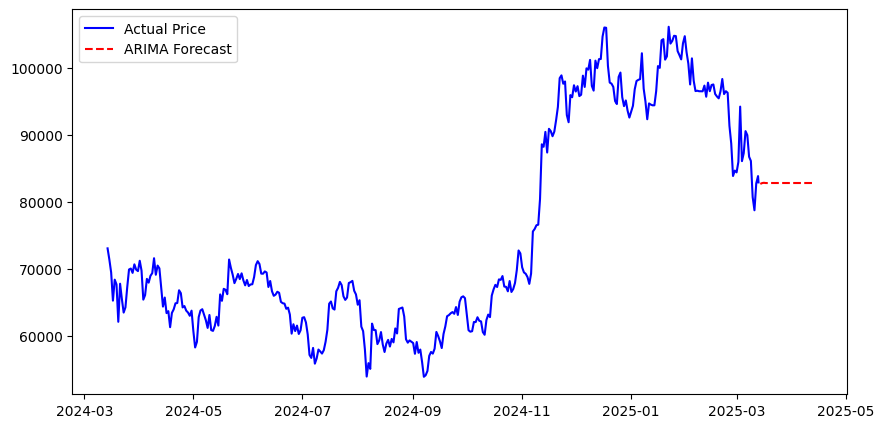

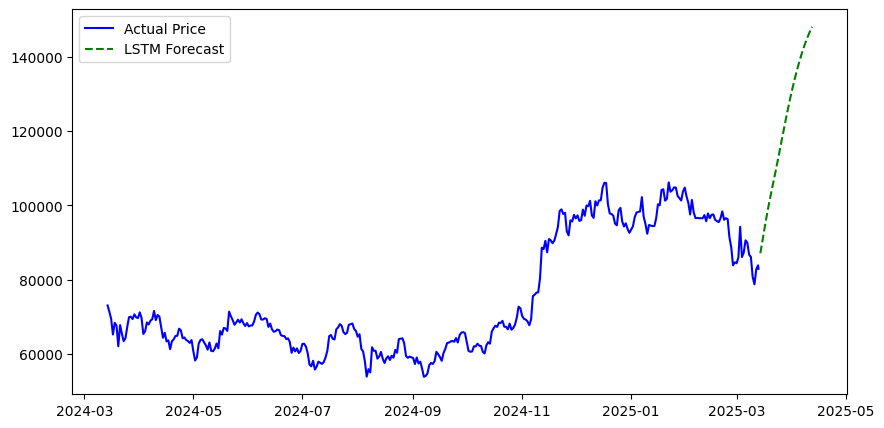

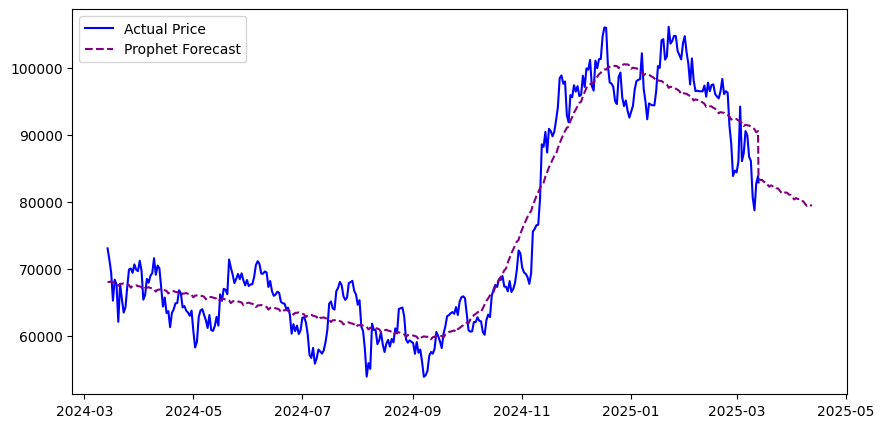

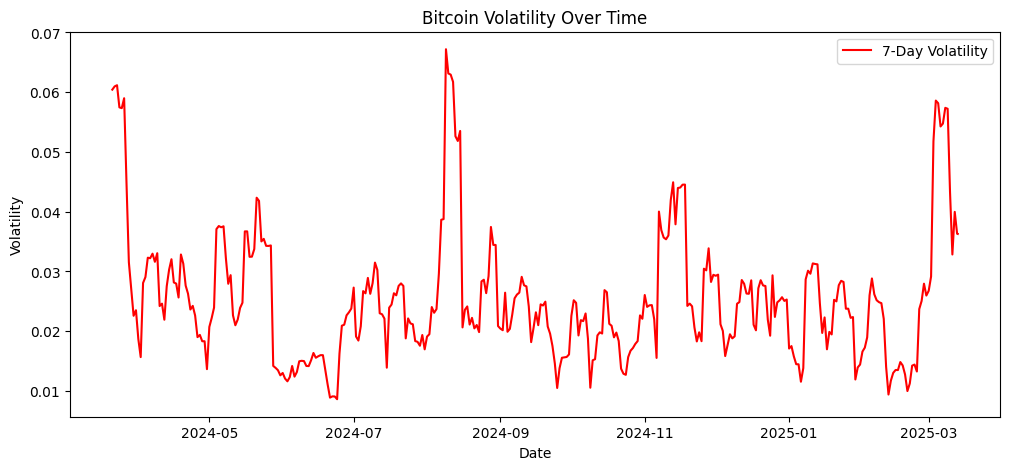

In [363]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Bitcoin Price Data
df = pd.read_csv("bitcoin_prices.csv", parse_dates=["Date"], index_col="Date")

# Calculate 7-day rolling volatility
df["Volatility"] = df["Price"].pct_change().rolling(7).std()

# Plot Volatility
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Volatility"], color="red", label="7-Day Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Bitcoin Volatility Over Time")
plt.legend()
plt.show()

In [364]:
!pip install tweepy nltk

In [365]:
import tweepy

# Add your Twitter API keys here
API_KEY = "LcQjbbPFxbztSDR1gMG7Y5B9J"
API_SECRET = "Ji4xgK0yR31a2ai8xDEsW6ysAKGGV8BRHyMk4MKacTGBCvbFRT"
ACCESS_TOKEN = "1899864433561911296-g1IPsPY2DuBjVlKsAL5uGuchTpdCaB"
ACCESS_SECRET = "NjWVXnETSlZzP1l645B2xh1jO1ObxKfGYNhJ8k5oIf2jj"

# Authenticate with Twitter API
auth = tweepy.OAuthHandler(API_KEY, API_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)  # Prevents API limit errors

# Test Authentication
try:
    api.verify_credentials()
    print("Twitter API Authentication Successful!")
except Exception as e:
    print(f"Error: {e}")

Error: 401 Unauthorized
32 - Could not authenticate you.


In [367]:
import tweepy
import time

# Add your Twitter API credentials
API_KEY = "LcQjbbPFxbztSDR1gMG7Y5B9J"
API_SECRET = "Ji4xgK0yR31a2ai8xDEsW6ysAKGGV8BRHyMk4MKacTGBCvbFRT"
ACCESS_TOKEN = "1899864433561911296-g1IPsPY2DuBjVlKsAL5uGuchTpdCaB"
ACCESS_SECRET = "NjWVXnETSlZzP1l645B2xh1jO1ObxKfGYNhJ8k5oIf2jj"
BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAGeTzwEAAAAAbLh4QAbyiGpRbitYKHDThFe9VwU%3DfiWAJHJQUKuKz1vPSpn6xhZJoipgFc87ckL2IWWeQ3uGwIwYa0"  # Required for API v2

# Authenticate using Tweepy v2
client = tweepy.Client(bearer_token=BEARER_TOKEN, wait_on_rate_limit=True) # Added wait_on_rate_limit=True

# Search for recent Bitcoin-related tweets
query = "Bitcoin OR BTC OR Cryptocurrency -is:retweet lang:en"
tweet_count = 10  # Number of tweets to fetch

# Fetch tweets with rate limiting handling
tweets = client.search_recent_tweets(query=query, max_results=tweet_count)

# Display some tweets
for tweet in tweets.data[:5]:  # Show first 5 tweets
    print(f"Tweet: {tweet.text}\n")
    time.sleep(5)  # Add a delay of 5 seconds between displaying tweets

Tweet: @0xASK That was a very convoluted way of saying, “Just use Bitcoin SV. It scales at Layer 1, so you don’t have to worry about all of that other sh¡t.”

Tweet: 男女共に初めての方大歓迎

日給5-15万円前後は稼げる仕事
紹介できます。

融資しますとは違います。

まずはDM

即金
高収入
コロナ
ニート
風俗
推し
副業
借金
返済
即日即金
BTC
融資
資金調達
投資
UD

闇バイト 裏仕事
028

Tweet: 🇷🇺 Russia’s Central Bank Shifts Stance on Crypto!

Wealthy investors may soon be allowed to trade crypto under a new three-year experimental legal regime. A major shift from Russia’s previous anti-crypto stance! 💰🔥

Bullish for adoption? 👀 #Crypto #Bitcoin #russia

Tweet: Abu Dhabi-backed investment group MGX has made a $2 billion cryptocurrency investment in Binance.

https://t.co/6ZIJbHSjme

Tweet: #Airdrop #BTC #Crypto #Bearmarket #Eth #trump https://t.co/fKI64T00wy



In [368]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download Sentiment Analysis Lexicon (if not already installed)
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

# Ensure tweets contain data
if tweets.data:
    # Extract text from each tweet and analyze sentiment
    sentiments = []
    for tweet in tweets.data:  # Use `.data` to access tweet text
        sentiment_score = sia.polarity_scores(tweet.text)["compound"]
        sentiments.append(sentiment_score)

    # Calculate Average Sentiment Score
    avg_sentiment = sum(sentiments) / len(sentiments)
    print(f"Average Sentiment Score: {avg_sentiment}")
else:
    print("No tweets found. Try a different search query.")


Average Sentiment Score: -0.01665999999999999


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [369]:
import pandas as pd

# Ensure tweets contain data
if tweets.data:
    # Extract text and sentiment scores
    tweet_texts = [tweet.text for tweet in tweets.data]  # Use `.data` to get tweet text
    df_sentiment = pd.DataFrame({
        "Tweet": tweet_texts,
        "Sentiment Score": sentiments
    })

    # Save to CSV
    df_sentiment.to_csv("crypto_sentiment.csv", index=False)
    print("Crypto Sentiment Data Saved to CSV!")
else:
    print("No tweets found. Try a different search query.")


Crypto Sentiment Data Saved to CSV!


In [370]:
import streamlit as st
import pandas as pd

# Load Sentiment Data
df_sentiment = pd.read_csv("crypto_sentiment.csv")

# Streamlit UI
st.title("Crypto Market Sentiment Analysis")
st.write("Real-time sentiment analysis of Bitcoin-related tweets.")

# Show latest sentiment scores
st.subheader("Sentiment Score Distribution")
st.bar_chart(df_sentiment["Sentiment Score"])

# Display sample tweets
st.subheader("Latest Tweets and Sentiments")
st.write(df_sentiment.head())

st.write("Stay Updated with Live Crypto Market Sentiment!")

2025-03-13 06:36:07.517 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:07.520 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:07.521 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:07.522 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:07.523 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:07.524 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:07.525 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:07.528 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [371]:
import logging
import os
import warnings

# Suppress Streamlit warnings
warnings.filterwarnings("ignore")
os.environ["STREAMLIT_SUPPRESS_ERRORS"] = "1"

# Suppress logging messages
logging.getLogger("streamlit").setLevel(logging.ERROR)
logging.getLogger("py.warnings").setLevel(logging.ERROR)

In [372]:
import pandas as pd
import streamlit as st

# Load Sentiment Data
df_sentiment = pd.read_csv("crypto_sentiment.csv")

# Show Sentiment Data in the Dashboard
st.title("Crypto Market Sentiment Analysis")
st.write("Sentiment analysis of Bitcoin-related tweets.")

st.subheader("Sentiment Data Preview")
st.write(df_sentiment.head())

2025-03-13 06:36:15.851 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:15.852 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:15.853 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:15.854 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:15.855 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:15.858 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:15.859 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:15.860 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [373]:
import matplotlib.pyplot as plt

# Calculate Sentiment Distribution
positive_tweets = len(df_sentiment[df_sentiment["Sentiment Score"] > 0])
neutral_tweets = len(df_sentiment[df_sentiment["Sentiment Score"] == 0])
negative_tweets = len(df_sentiment[df_sentiment["Sentiment Score"] < 0])

# Display Sentiment Distribution in a Bar Chart
st.subheader("📊 Sentiment Distribution")

fig, ax = plt.subplots()
ax.bar(["Positive", "Neutral", "Negative"], [positive_tweets, neutral_tweets, negative_tweets], color=["green", "gray", "red"])
ax.set_ylabel("Number of Tweets")
ax.set_title("Sentiment Analysis of Bitcoin Tweets")
st.pyplot(fig)

2025-03-13 06:36:20.016 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:20.017 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:20.043 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:20.225 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:20.228 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [374]:
# Dropdown to Filter Tweets
sentiment_filter = st.selectbox("🔍 Select Sentiment to View Tweets", ["All", "Positive", "Neutral", "Negative"])

# Filter Data
if sentiment_filter == "Positive":
    filtered_df = df_sentiment[df_sentiment["Sentiment Score"] > 0]
elif sentiment_filter == "Negative":
    filtered_df = df_sentiment[df_sentiment["Sentiment Score"] < 0]
elif sentiment_filter == "Neutral":
    filtered_df = df_sentiment[df_sentiment["Sentiment Score"] == 0]
else:
    filtered_df = df_sentiment

# Display Filtered Tweets
st.subheader(f"📢 {sentiment_filter} Tweets")
st.write(filtered_df[["Tweet", "Sentiment Score"]])

2025-03-13 06:36:26.348 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:26.350 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:26.351 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:26.352 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:26.353 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:26.354 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:26.356 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 06:36:26.357 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [375]:
import threading
import subprocess
from pyngrok import ngrok

# Kill old processes
!kill -9 $(pgrep streamlit)
!kill -9 $(pgrep ngrok)

# Start Streamlit
def run_streamlit():
    subprocess.run(["streamlit", "run", "app.py", "--server.port", "8501", "--browser.serverAddress", "0.0.0.0"])

thread = threading.Thread(target=run_streamlit)
thread.start()

# Start ngrok
public_url = ngrok.connect(addr="8501")
print(f"Streamlit App is Running at: {public_url}")

Streamlit App is Running at: NgrokTunnel: "https://540c-35-236-221-231.ngrok-free.app" -> "http://localhost:8501"


In [376]:
import pandas as pd
df = pd.read_csv("crypto_sentiment.csv")
print(df.head())

                                               Tweet  Sentiment Score
0  @0xASK That was a very convoluted way of sayin...          -0.4404
1  男女共に初めての方大歓迎\n\n日給5-15万円前後は稼げる仕事\n紹介できます。\n\n融...           0.0000
2  🇷🇺 Russia’s Central Bank Shifts Stance on Cryp...           0.5550
3  Abu Dhabi-backed investment group MGX has made...           0.0000
4  #Airdrop #BTC #Crypto #Bearmarket #Eth #trump ...           0.0000


In [377]:
import pandas as pd

# Check if sentiment data exists
try:
    df_sentiment = pd.read_csv("crypto_sentiment.csv")
    print("Sentiment Data Found!")
    print(df_sentiment.head())  # Show first 5 rows
except FileNotFoundError:
    print("ERROR: Sentiment data file not found! Run sentiment analysis again.")

Sentiment Data Found!
                                               Tweet  Sentiment Score
0  @0xASK That was a very convoluted way of sayin...          -0.4404
1  男女共に初めての方大歓迎\n\n日給5-15万円前後は稼げる仕事\n紹介できます。\n\n融...           0.0000
2  🇷🇺 Russia’s Central Bank Shifts Stance on Cryp...           0.5550
3  Abu Dhabi-backed investment group MGX has made...           0.0000
4  #Airdrop #BTC #Crypto #Bearmarket #Eth #trump ...           0.0000


In [378]:
!pip install --upgrade streamlit

In [379]:
!ls

app.py				crypto_dashboard	 prophet_forecast.csv
arima_forecast.csv		crypto_sentiment.csv	 sample_data
binancecoin_prices.csv		ethereum_prices.csv	 updated_arima_forecast.csv
bitcoin_prices.csv		live_bitcoin_prices.csv
bitcoin_prices_for_powerbi.csv	lstm_forecast.csv


In [380]:
%%writefile app.py
import streamlit as st
st.title("Streamlit Dashboard")
st.write("This is the starting point of your dashboard.")

Overwriting app.py


In [381]:
!cat app.py

import streamlit as st
st.title("Streamlit Dashboard")
st.write("This is the starting point of your dashboard.")


In [382]:
import os

files = ["bitcoin_prices.csv", "arima_forecast.csv", "lstm_forecast.csv", "prophet_forecast.csv", "crypto_sentiment.csv"]

for file in files:
    if os.path.exists(file):
        print(f"{file} exists!")
    else:
        print(f"ERROR: {file} is missing! Please generate it again.")


bitcoin_prices.csv exists!
arima_forecast.csv exists!
lstm_forecast.csv exists!
prophet_forecast.csv exists!
crypto_sentiment.csv exists!


In [383]:
import pandas as pd

# Check if bitcoin_prices.csv exists
try:
    df = pd.read_csv("bitcoin_prices.csv")
    print("Bitcoin Price Data Found!")
    print(df.head())  # Display first few rows
except FileNotFoundError:
    print("ERROR: bitcoin_prices.csv not found! Generate it again.")


Bitcoin Price Data Found!
                  Date         Price
0  2024-03-14 00:00:00  73097.767027
1  2024-03-15 00:00:00  71420.031801
2  2024-03-16 00:00:00  69497.763193
3  2024-03-17 00:00:00  65292.313293
4  2024-03-18 00:00:00  68425.415656


In [384]:
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

# ---- Load Data ----
try:
    # Load Bitcoin Price Data
    df_prices = pd.read_csv("bitcoin_prices.csv", parse_dates=["Date"], index_col="Date")

    # Load Forecasting Data
    df_arima = pd.read_csv("arima_forecast.csv", parse_dates=["Date"], index_col="Date")
    df_lstm = pd.read_csv("lstm_forecast.csv", parse_dates=["Date"], index_col="Date")
    df_prophet = pd.read_csv("prophet_forecast.csv", parse_dates=["Date"], index_col="Date")

    # Load Sentiment Data
    df_sentiment = pd.read_csv("crypto_sentiment.csv")

    # ---- Streamlit UI ----
    st.title("📈 Cryptocurrency Price Forecasting & Sentiment Analysis")
    st.write("Analyze Bitcoin trends using ARIMA, LSTM, Prophet, and sentiment analysis from Twitter.")

    # ---- Bitcoin Price Data ----
    st.subheader("Bitcoin Price Data")
    st.write("Here is the raw Bitcoin price data used for analysis:")
    st.dataframe(df_prices.tail())  # Show last few rows of price data

    # ---- Bitcoin Price Trend ----
    st.subheader("Bitcoin Price Trend")
    st.line_chart(df_prices["Price"])

    # ---- ARIMA Forecast ----
    st.subheader("ARIMA Model Prediction")
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_prices.index, df_prices["Price"], label="Actual Price", color="blue")
    ax.plot(df_arima.index, df_arima["Forecast"], label="ARIMA Forecast", linestyle="dashed", color="red")
    ax.legend()
    st.pyplot(fig)

    # ---- LSTM Forecast ----
    st.subheader("LSTM Model Prediction")
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_prices.index, df_prices["Price"], label="Actual Price", color="blue")
    ax.plot(df_lstm.index, df_lstm["Forecast"], label="LSTM Forecast", linestyle="dashed", color="green")
    ax.legend()
    st.pyplot(fig)

    # ---- Prophet Forecast ----
    st.subheader("Prophet Model Prediction")
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_prices.index, df_prices["Price"], label="Actual Price", color="blue")
    ax.plot(df_prophet.index, df_prophet["Forecast"], label="Prophet Forecast", linestyle="dashed", color="purple")
    ax.legend()
    st.pyplot(fig)

    # ---- Sentiment Analysis ----
    st.subheader("Crypto Market Sentiment Analysis")
    st.write("Sentiment analysis of Bitcoin-related tweets.")

    # Show Sentiment Data
    st.subheader("Sentiment Data Preview")
    st.write(df_sentiment.head())  # Show first few tweets & scores

    # Calculate Sentiment Distribution
    positive_tweets = len(df_sentiment[df_sentiment["Sentiment Score"] > 0])
    neutral_tweets = len(df_sentiment[df_sentiment["Sentiment Score"] == 0])
    negative_tweets = len(df_sentiment[df_sentiment["Sentiment Score"] < 0])

    # Show Sentiment Distribution Chart
    st.subheader("Sentiment Distribution")
    fig, ax = plt.subplots()
    ax.bar(["Positive", "Neutral", "Negative"], [positive_tweets, neutral_tweets, negative_tweets], color=["green", "gray", "red"])
    ax.set_ylabel("Number of Tweets")
    ax.set_title("Sentiment Analysis of Bitcoin Tweets")
    st.pyplot(fig)

    # Show Overall Market Sentiment
    avg_sentiment = df_sentiment["Sentiment Score"].mean()
    st.subheader("Overall Crypto Market Sentiment")
    if avg_sentiment > 0:
        st.write(f"🟢 **Positive Market Sentiment** (Score: {avg_sentiment:.2f})")
    elif avg_sentiment < 0:
        st.write(f"🔴 **Negative Market Sentiment** (Score: {avg_sentiment:.2f})")
    else:
        st.write(f"⚪ **Neutral Market Sentiment** (Score: {avg_sentiment:.2f})")

    # Dropdown to Filter Tweets by Sentiment
    sentiment_filter = st.selectbox("🔍 Select Sentiment to View Tweets", ["All", "Positive", "Neutral", "Negative"])
    if sentiment_filter == "Positive":
        filtered_df = df_sentiment[df_sentiment["Sentiment Score"] > 0]
    elif sentiment_filter == "Negative":
        filtered_df = df_sentiment[df_sentiment["Sentiment Score"] < 0]
    elif sentiment_filter == "Neutral":
        filtered_df = df_sentiment[df_sentiment["Sentiment Score"] == 0]
    else:
        filtered_df = df_sentiment

    # Display Filtered Tweets
    st.subheader(f"{sentiment_filter} Tweets")
    st.write(filtered_df[["Tweet", "Sentiment Score"]])

except FileNotFoundError as e:
    st.error(f"Error loading data: {e}")


Overwriting app.py


In [385]:
import threading
import subprocess
from pyngrok import ngrok

# Kill old Streamlit and ngrok processes (if any)
!kill -9 $(pgrep streamlit)
!kill -9 $(pgrep ngrok)

# Start Streamlit in a separate thread
def run_streamlit():
    subprocess.run(["streamlit", "run", "app.py", "--server.port", "8501", "--browser.serverAddress", "0.0.0.0"])

thread = threading.Thread(target=run_streamlit)
thread.start()

# Start ngrok to expose the Streamlit app
public_url = ngrok.connect(addr="8501")
print(f"Streamlit App is Running at: {public_url}")


Streamlit App is Running at: NgrokTunnel: "https://686b-35-236-221-231.ngrok-free.app" -> "http://localhost:8501"
